**PART 3 - DSIM PROJECT**

Francesca De Cola, Valentina Moretto, Valentina Zangirolami

In this notebook, we have used VGGFace neural network. This is provided by the following link of github (https://github.com/rcmalli/keras-vggface.git). We decided to use this network because is trained with facial images while a classical pre-trained network provided by keras is trained on ImageNet dataset that is more different than our case. 

Pre-trained network are more useful to improve performance.

In this notebook, VGGFace is used for the extraction of the features of our images:
this technique permits to reduce dimensionality of the data and extract the important features of images.

Finally, we compare different machine learning alghoritms with hyperparameters optimazation.

In [ ]:
#!pip install git+https://github.com/rcmalli/keras-vggface.git --user
#!pip install keras_applications
#!pip install -U scikit-learn

  Cloning https://github.com/rcmalli/keras-vggface.git to c:\users\valen\appdata\local\temp\pip-req-build-6iej238_
  Using cached scipy-1.6.3-cp37-cp37m-win_amd64.whl (32.6 MB)


  Running command git clone -q https://github.com/rcmalli/keras-vggface.git 'C:\Users\valen\AppData\Local\Temp\pip-req-build-6iej238_'


**Load and import packages**

In [ ]:
import keras_vggface 
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras_vggface.utils import decode_predictions

Using TensorFlow backend.
C:\Users\valen\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\valen\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\valen\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\valen\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [ ]:
import keras_applications
import keras
from keras_vggface import utils

from PIL import Image
import random as rnd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style

from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split , StratifiedKFold, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import cv2 as cv
import os
import random

In [ ]:
from keras.datasets import mnist 
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Model, Sequential, load_model
from keras.utils import to_categorical, np_utils 
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from keras_vggface import utils

In [ ]:
import tensorflow as tf

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
gpu_options = tf.GPUOptions(visible_device_list="0")
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

**Seed for reproducibility**

In [ ]:
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

**Preprocessing e Feature extractor**

We load a dataset of images created in the previous notebook (creation_dataset.ipynb). It contains facial images related to the seven emotions (angry, happy, sad, neutral, surprise, fear, disgust).

In [ ]:
train=np.load("C:/Users/valen/Desktop/magistrale/DSIM/dataset_imgs.npz")
label=train['Y'] #label
img=train['X'] #images
img.shape 

(2269, 224, 224, 3)

Initially, we use pre-trained neural network 'VGGFace' such as feature extractor. We load senet50 model of VGGFace.

In [ ]:
base_model = VGGFace(include_top = False, input_shape = (224, 224, 3), model='senet50')

Before training phase, we transform pixel of images to float and apply preprocessing function of resnet-50 of vggface. This function rescale pixel of images.

In [ ]:
img=img.astype('float64')
img = utils.preprocess_input(img,version=2)

Structure of resnet-50 VGGFace:

In [ ]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
__________________________________________________________________________________________________
max_poolin

In the following lines we focus on feature extraction. We cut the base model at the layer *global_average_pooling_2d_14* and with the command *predict* we extract feauture of our images.

In [ ]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer("global_average_pooling2d_14").output)

In [ ]:
img = model.predict(img)
img.shape

(2269, 2048)

Initially, we divide the complete dataset into two partition (train and test set). 

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(img, label, test_size = .2, random_state = SEED, stratify = label)

**Cross validation 5-folds**

We used a 5-folds cross validation to evaluate three model:
1. Random Forest
2. Support Vector Machine
3. K-nearest neighbord

Furthermore, this approch is used for tune and test the three models. 

For hyperparameters optimization, we use a grid search randomize that allows to select a combination of hyperparameters randomly with efficient computation time than grid search.

In [ ]:
kfold_acc = {}
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)
# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

**Random Forest**

We define a limited range of possible value for each hyperparameters of random forest:
* number of trees: a range of value from 200 to 2000 (n_estimators)
* max_depth: represents the maximum depth of tree (10,110)
* max_features: the number of features to consider for each split
* min_samples_split: minimum number of samples required to split a node 
* min_samples_leaf: minimum number of samples required at each leaf node
* bootstrap: boolean value for the choice to use bootstrap samples when building trees.


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
clf = RandomForestClassifier()
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'log2']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = kfold, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)
rf_random.best_params_
rf_random.best_score_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


0.8947658402203856

We evaluate model to test set with best parameters selecting by randomized grid search. 

We define classification report and confusion matrix that can be used to evaluate performance for each classes.

Metrics:
* Precision, represents the number of correctly predicted instances
* Recall, is a measure of sensibility of the model. It is a fraction of number of corrected prediction and number of total cases effective
* f1-score, is an harmonic mean of precision and recall.

Classification report:
              precision    recall  f1-score   support

       angry       0.84      0.92      0.88        64
     disgust       0.88      0.87      0.87        60
        fear       0.92      0.87      0.89        63
       happy       0.98      0.92      0.95        64
     neutral       0.85      0.93      0.89        69
         sad       0.92      0.78      0.84        73
    surprise       0.85      0.95      0.90        61

    accuracy                           0.89       454
   macro avg       0.89      0.89      0.89       454
weighted avg       0.89      0.89      0.89       454

Confusion matrix:
[[59  3  0  0  0  2  0]
 [ 6 52  0  0  0  1  1]
 [ 0  0 55  0  2  1  5]
 [ 0  1  0 59  2  0  2]
 [ 0  0  2  1 64  1  1]
 [ 5  3  2  0  5 57  1]
 [ 0  0  1  0  2  0 58]]


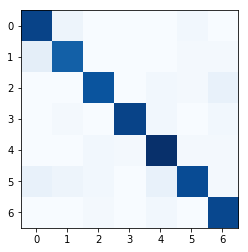

In [ ]:
y_pred=rf_random.predict(x_test)
print('Classification report:')
print(classification_report(y_test, y_pred))

print('Confusion matrix:')
cm=confusion_matrix(y_test, y_pred)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

The score of accuracy is 89%. Class 'happy' perform very well in terms of precision, recall and f1-score. Other classes have always high value of metrics, but the power of classification is lower.

**SVC**

We define a grid of hyperparameters for SVC:
* C is a parameters of regularization
* class_weight is used to choice to balance or not the label classes
* gamma represent the kernel coefficients
* kernel represent the kernel type to be used in the algorithm

In [ ]:
clf = SVC()
svc_grid = {'C': [0.1, 1, 10, 100, 1000], 'class_weight':['balanced','None'],'gamma': ['scale', 'auto'], 'kernel':  ['poly', 'rbf', 'sigmoid']}
svc_random = RandomizedSearchCV(estimator = clf, param_distributions = svc_grid, n_iter = 60, cv = kfold, verbose=2, random_state=42, n_jobs = -1)
svc_random.fit(img, label)
svc_random.best_params_
svc_random.best_score_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


C:\Users\valen\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [0.88276201 0.78537698 0.31512968 0.14676605 0.14676605 0.14676605
        nan        nan        nan        nan        nan        nan
 0.91361652 0.89158133 0.67342922 0.14676605 0.26574963 0.14852817
        nan        nan        nan        nan        nan        nan
 0.92639671 0.91846525 0.59277455 0.1529529  0.80168626 0.74570314
        nan        nan        nan        nan        nan        nan
 0.92551565 0.92243098 0.52666122 0.1520524  0.88672677 0.8721864
        nan        nan        nan        nan        nan        nan
 0.92551565 0.92243098 0.48038432 0.15072789 0.90832531 0.9065632
        nan        nan        nan        nan        nan        nan]
  category=UserWarning


0.9263967091635792

We evaluate model to test set with best parameters selecting by randomized grid search. 

Classification report:
              precision    recall  f1-score   support

       angry       1.00      1.00      1.00        64
     disgust       1.00      1.00      1.00        60
        fear       1.00      1.00      1.00        63
       happy       1.00      1.00      1.00        64
     neutral       1.00      1.00      1.00        69
         sad       1.00      1.00      1.00        73
    surprise       1.00      1.00      1.00        61

    accuracy                           1.00       454
   macro avg       1.00      1.00      1.00       454
weighted avg       1.00      1.00      1.00       454

Confusion matrix:
[[64  0  0  0  0  0  0]
 [ 0 60  0  0  0  0  0]
 [ 0  0 63  0  0  0  0]
 [ 0  0  0 64  0  0  0]
 [ 0  0  0  0 69  0  0]
 [ 0  0  0  0  0 73  0]
 [ 0  0  0  0  0  0 61]]


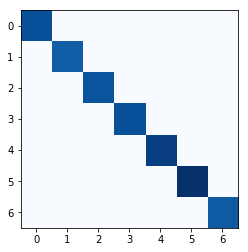

In [ ]:
y_pred_svc=svc_random.predict(x_test)
print('Classification report:')
print(classification_report(y_test, y_pred_svc))

print('Confusion matrix:')
cm=confusion_matrix(y_test, y_pred_svc)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

Accuracy value of cross validation is very high (92%). In the test phase, we obtain an accuracy of 100%. SVC results is better than random forest.

**KNN**

We define a grid of hyperparameters of KNN:
* n_neighbors represent the number of neighbors consider in KNN
* weights is the weight function used in prediction (Uniform: All points in each neighborhood are weighted equally, Distance weight is the inverse of the points distance)
* p represent the parameter of minkowski distance

In [ ]:
knn = KNeighborsClassifier()
knn_grid = {'n_neighbors': [5,7,9,12, 15, 20, 25, 30, 35, 40, 50], 'weights':['uniform','distance'],'p': list(range(1,6))}
knn_random = RandomizedSearchCV(estimator = knn, param_distributions = knn_grid, n_iter = 95, cv = kfold, verbose=2, random_state=42, n_jobs = -1)
knn_random.fit(img, label)
knn_random.best_params_
knn_random.best_score_

Fitting 5 folds for each of 95 candidates, totalling 475 fits


0.8386965020275987

We evaluate model to test set with best parameters selecting by randomized grid search. 

Classification report:
              precision    recall  f1-score   support

       angry       1.00      1.00      1.00        64
     disgust       1.00      1.00      1.00        60
        fear       1.00      1.00      1.00        63
       happy       1.00      1.00      1.00        64
     neutral       1.00      1.00      1.00        69
         sad       1.00      1.00      1.00        73
    surprise       1.00      1.00      1.00        61

    accuracy                           1.00       454
   macro avg       1.00      1.00      1.00       454
weighted avg       1.00      1.00      1.00       454

Confusion matrix:
[[64  0  0  0  0  0  0]
 [ 0 60  0  0  0  0  0]
 [ 0  0 63  0  0  0  0]
 [ 0  0  0 64  0  0  0]
 [ 0  0  0  0 69  0  0]
 [ 0  0  0  0  0 73  0]
 [ 0  0  0  0  0  0 61]]


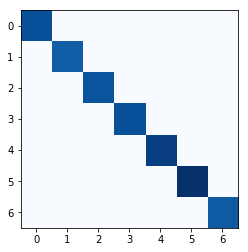

In [ ]:
y_pred_knn=knn_random.predict(x_test)
print('Classification report:')
print(classification_report(y_test, y_pred_knn))

print('Confusion matrix:')
cm=confusion_matrix(y_test, y_pred_knn)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

In the test set we obtain a very high value of accuracy (100%) but in the cross validation phase we obtain the worst value. For this reason, we save only the svc models to compare it with subsequent algorithms.

In [ ]:
import joblib
filename = 'C:/Users/valen/Desktop/magistrale/DSIM/svc_model.sav'
joblib.dump(svc_random, filename)

['C:/Users/valen/Desktop/magistrale/DSIM/svc_model.sav']